# Thick Sample Ptychography Forward Model Tutorial 2D

This tutorial demonstrates how to use `thick_ptycho` to set up and solve a 2D forward problem with multiple probes, both iteratively and as a full system.


The forward model solves the paraxial equation:

\begin{equation}
\frac{\partial u}{\partial z} = a \frac{\partial^2 u}{\partial x^2}  + C(x, z) u,
\end{equation}
where
\begin{equation}
a := \frac{1}{2ik} \qquad \text{and} \qquad C(x, z) := \frac{k}{2i} \left(n^2(x, z) - 1\right)
\end{equation}


**$n$ defines the refractive index of the volume. $k$ is the wave number.**

### 1. Import Libraries: Sample Space and Forward Model


In [1]:
from thick_ptycho.simulation.config import SimulationConfig, ProbeType, ProbeConfig
from thick_ptycho.simulation.scan_frame import Limits
from thick_ptycho.forward_model.pwe.operators import BoundaryType
from thick_ptycho.simulation.simulation_space import create_simulation_space
from thick_ptycho.simulation.ptycho_object import create_ptycho_object
from thick_ptycho.simulation.ptycho_probe import create_ptycho_probes
from thick_ptycho.forward_model import PWEIterativeLUSolver, PWEPetscFullPinTSolver
import time

from thick_ptycho.reconstruction.ms_reconstructor import ReconstructorMS
from thick_ptycho.reconstruction.pwe_reconstructor import ReconstructorPWE


import numpy as np

from utils import create_random_circle_object, plot_probes, plot_data, plot_solution

### Simulated Probe Configuration

In [2]:
probe_config = ProbeConfig(
    type=ProbeType.AIRY_DISK,
    wave_length=0.635e-6,  # meters (0.635 μm). Visible light
    diameter=10e-6,  # [m]
    focus=-5e-6,  # focal length [m]
    # tilts=(np.linspace(-15,15,3)) # tilts in degrees
)

### Discretization Parameters and Spatial Limits

In [3]:
# Width Discretization (Pixels)
scan_points = 60
step_size_px = 10
pad_factor = 1.8  # Must be >= 1.0
# Overlap = N - (scan_points*step_size_px) = padding
# Overlap factor = (N - (scan_points*step_size_px)) / step_size_px
#                = (pad_factor*scan_points) - scan_points) = scan_points*(pad_factor - 1)
# N = int(pad_factor*scan_points*step_size_px)
solve_reduced_domain = True

# Thickness Discretization (Pixels)
points_per_wavelength = 4
# Then:
#  - dz = wavelength / points_per_wavelength
#  - nz = int((zlims[1] - zlims[0]) / dz)
# Override by setting nz directly


# --- Simulation spatial dimensions (in meters) ---
spatial_limits = Limits(
    x=(0.0, 150e-6),  # Sample width
    z=(0.0, 40e-6),  # Sample thickness
    units="meters",
)

### Simulation Config

2025-12-14 03:31:21,462 - INFO - === Scan Summary ===
2025-12-14 03:31:21,464 - INFO -   Sample space (x-range): 1.500e-04 m
2025-12-14 03:31:21,466 - INFO -   Sample space (z-range): 4.000e-05 m
2025-12-14 03:31:21,467 - INFO -   Sample Pixels:          1081 px
2025-12-14 03:31:21,469 - INFO -   Step size:              10 px
2025-12-14 03:31:21,471 - INFO -   Number of scan points:  60
2025-12-14 03:31:21,473 - INFO -   Steps in z:             251
2025-12-14 03:31:21,476 - INFO -   Solve reduced domain:   490 px
2025-12-14 03:31:21,476 - INFO -   Max Overlap Pixels:     481 px
2025-12-14 03:31:21,478 - INFO -   Probe diameter:         1.000e-05 m
2025-12-14 03:31:21,481 - INFO -   Probe Pixels:           72 px
2025-12-14 03:31:21,484 - INFO -   Max Overlap:            8.611e-06 m
2025-12-14 03:31:21,485 - INFO -   Percentage Overlap:     86.11%



Padding/Overlap: 481


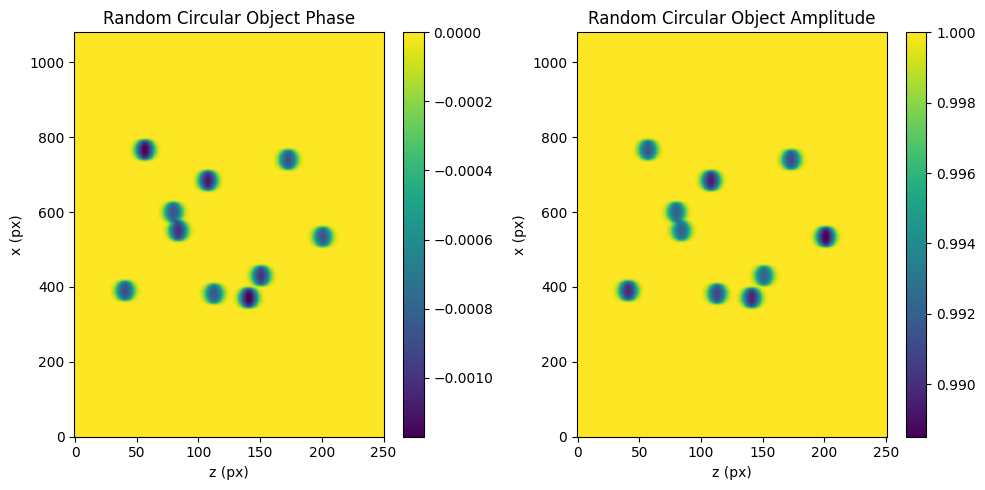

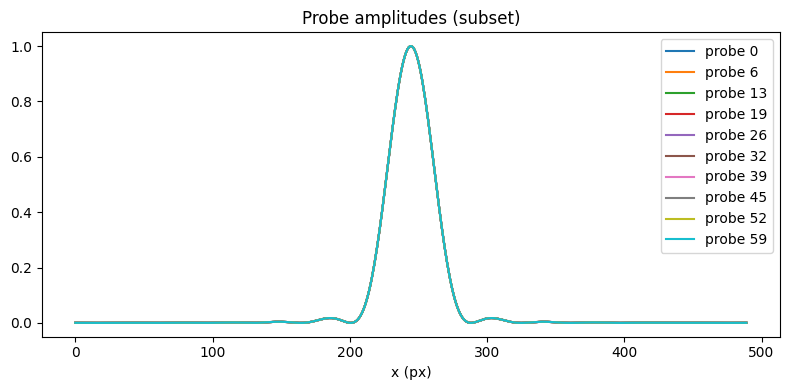

In [4]:
# --- Create the SimulationConfig object ---
# Defines scan path, probe parameters, discretization,
# object domain.
# Solver parameters are defined in the solver classes.
sim_config = SimulationConfig(
    probe_config=probe_config,
    # Spatial discretization
    scan_points=scan_points,
    step_size_px=step_size_px,
    pad_factor=pad_factor,
    solve_reduced_domain=solve_reduced_domain,
    points_per_wavelength=points_per_wavelength,
    spatial_limits=spatial_limits,
    # Refractive index or Transmission Function Constant Surrounding Medium
    medium=1.0,  # 1.0 for free space
    # Logging and results
    results_dir="./results",
    use_logging=True,
)

# --- Create the simulation space ---
simulation_space = create_simulation_space(sim_config)
simulation_space.summarize()
print("Padding/Overlap:", simulation_space.nx - simulation_space.min_nx)

# --- Create a Simultated Ptycho Object ---
# --- Create a Simultated Ptycho Object ---
ptycho_object = create_ptycho_object(simulation_space)

ptycho_object = create_random_circle_object(simulation_space, ptycho_object)


# --- Create a set of Simulated Ptycho Probes (not dependent on number of slices/steps) ---
ptycho_probes = create_ptycho_probes(simulation_space)

plot_probes(simulation_space, ptycho_probes)

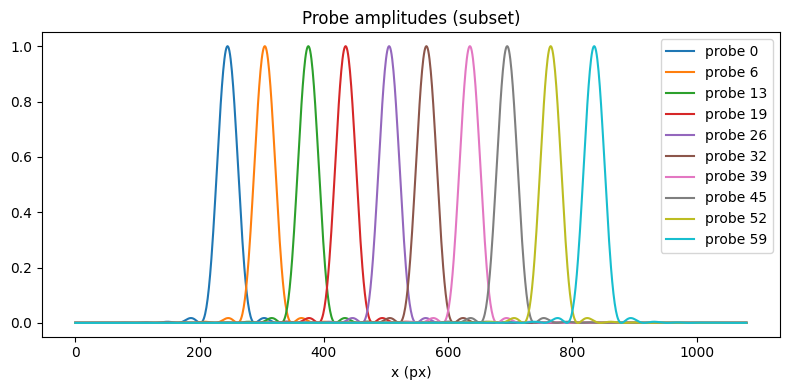

In [5]:
# Full scan view
sim_config_full = SimulationConfig(
    # Probe parameters
    probe_config=probe_config,
    # Spatial discretization
    scan_points=scan_points,
    step_size_px=step_size_px,
    pad_factor=pad_factor,
    solve_reduced_domain=False,
    points_per_wavelength=points_per_wavelength,
    spatial_limits=spatial_limits,
    # Refractive index or Transmission Function Constant Surrounding Medium
    medium=1.0,  # 1.0 for free space
    # Logging and results
    results_dir="./results",
    use_logging=True,
)
simulation_space_full = create_simulation_space(sim_config_full)
# --- Create a set of Simulated Ptycho Probes ---
ptycho_probes_full = create_ptycho_probes(simulation_space_full)

plot_probes(simulation_space_full, ptycho_probes_full)

### 5. Solve the Forward Model


Solution is a complex propagated field, shape:

(num_projections, num_angles, num_probes, nx[,ny], nz).

In [6]:
# Solve Full Space Space, Iterative
# --- Enumerated configuration types ---
bc_type = BoundaryType.IMPEDANCE

# --- Create Forward Model ---
time_start = time.time()
forward_model_pwe = PWEPetscFullPinTSolver(
    simulation_space, ptycho_probes, bc_type=bc_type, alpha=1e-8, atol=5e-2
)


# Iterative solution
u_pwe = forward_model_pwe.solve(n=ptycho_object.refractive_index)
time_end = time.time()
print(
    f"Forward model creation and solving time: {time_end - time_start:.2f} seconds.\n"
)
data_ew = forward_model_pwe.get_exit_waves(u_pwe)
data = forward_model_pwe.get_farfield_intensities(
    exit_waves=data_ew, poisson_noise=False
)

/home/dnz75396/thick_ptycho/thick_ptycho/forward_model/pwe/solvers/utils/_pint_utils.py:120: SparseEfficiencyWarning: splu converted its input to CSC format
  spla.splu((self.A_bar - (z * self.B_bar)).astype(self.dtype))


Forward model creation and solving time: 8.43 seconds.



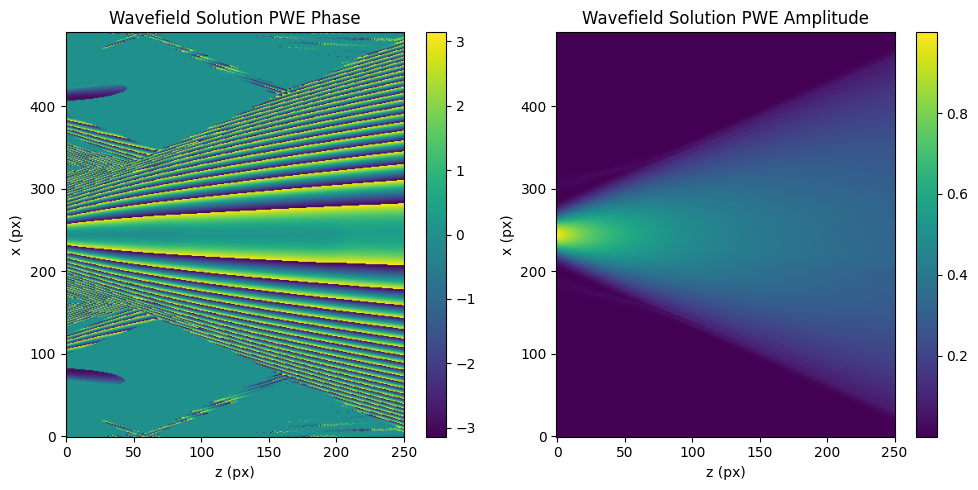

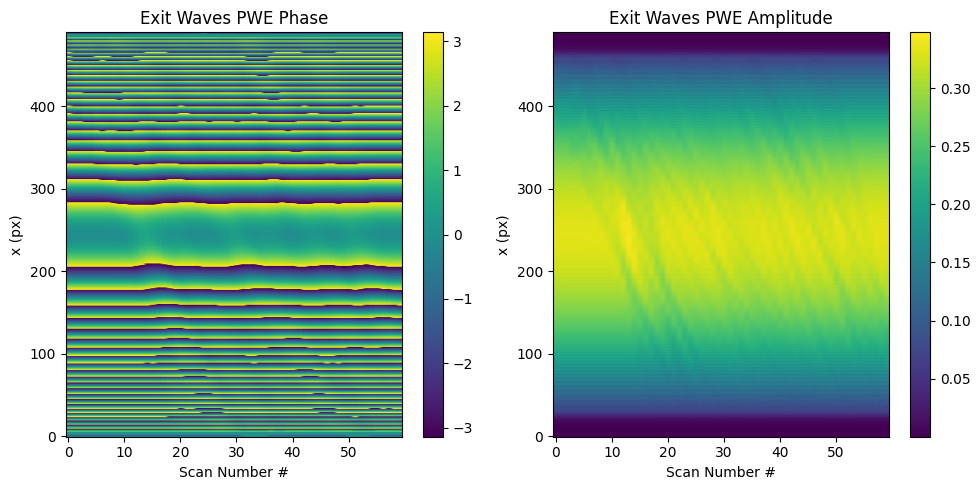

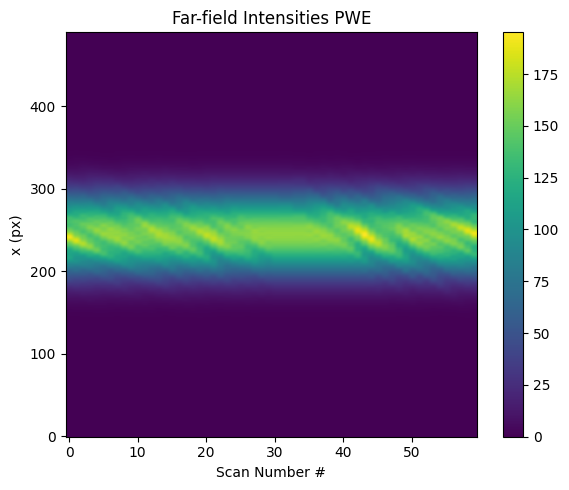

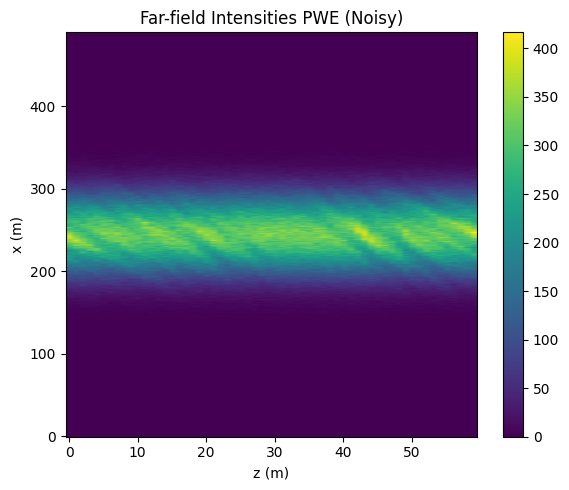

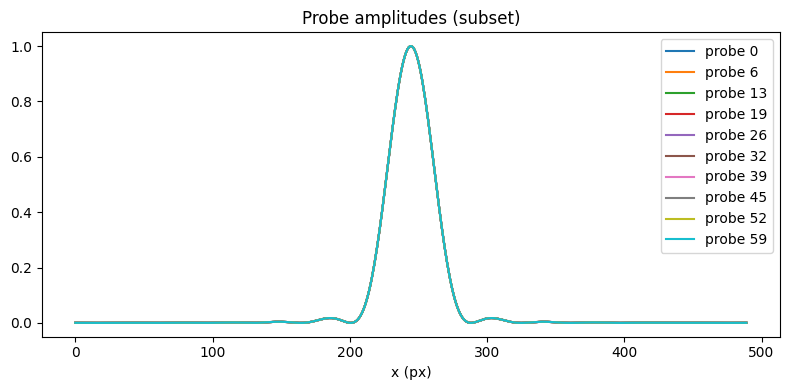

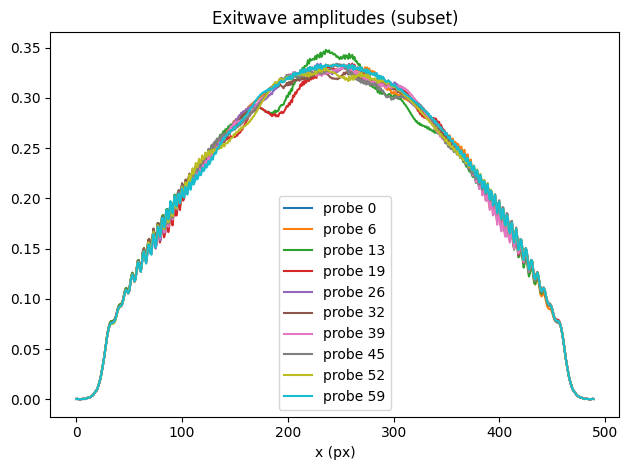

In [7]:
plot_solution(simulation_space, solution=u_pwe)
plot_data(simulation_space, data=data, exitwaves=data_ew, probes=ptycho_probes)

In [8]:
# --- Create Forward Model ---
time_start = time.time()
forward_model_pwe_empty = PWEPetscFullPinTSolver(
    simulation_space, ptycho_probes, bc_type=bc_type, alpha=1e-6, atol=5e-3
)

# Iterative solution
u_pwe_empty = forward_model_pwe_empty.solve(
    n=np.ones_like(ptycho_object.refractive_index)
)
time_end = time.time()
print(
    f"Forward model creation and solving time: {time_end - time_start:.2f} seconds.\n"
)
data_ew_empty = forward_model_pwe_empty.get_exit_waves(u_pwe_empty)
data_empty = forward_model_pwe_empty.get_farfield_intensities(
    exit_waves=data_ew_empty, poisson_noise=False
)

Forward model creation and solving time: 1.78 seconds.



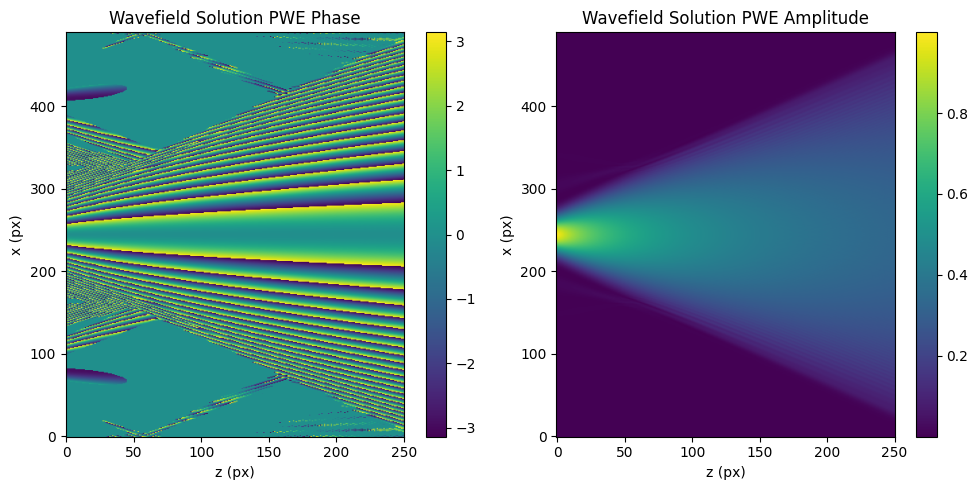

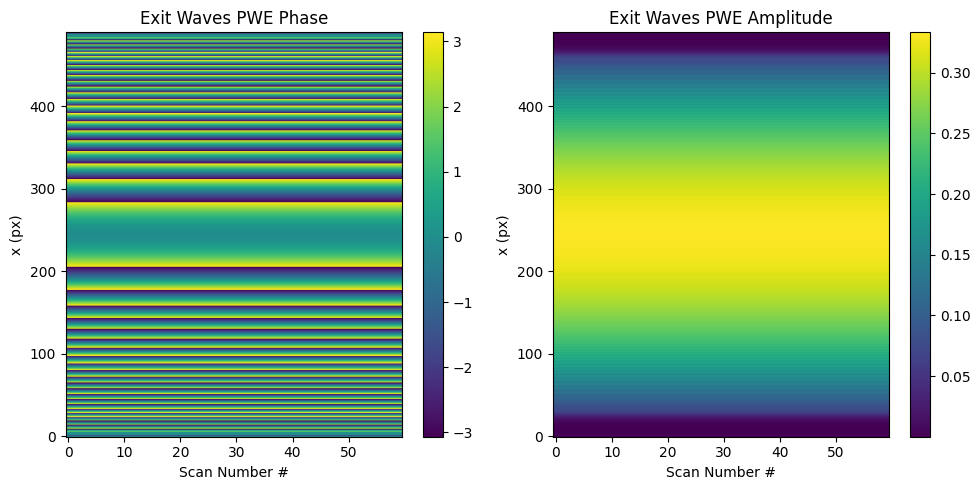

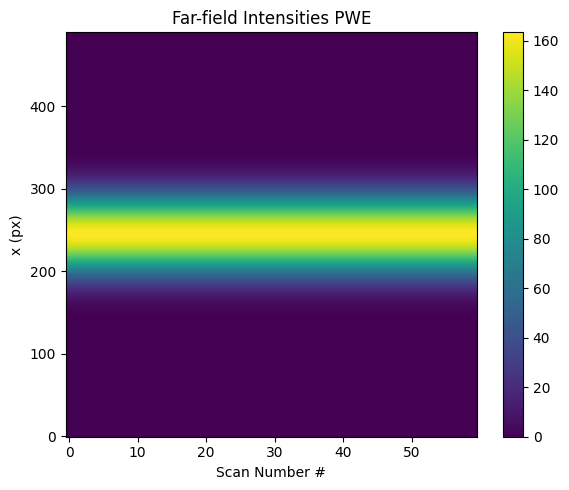

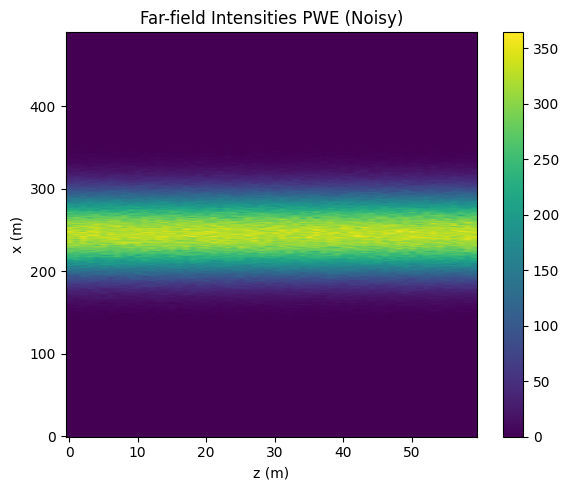

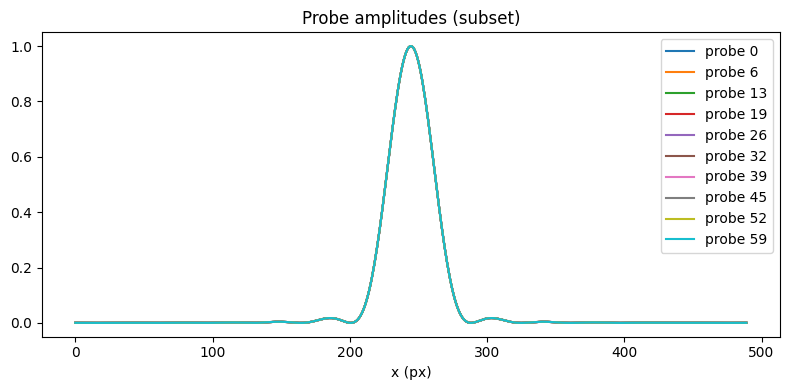

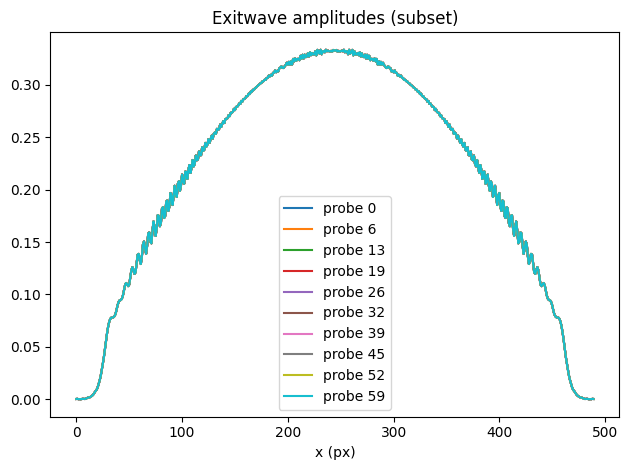

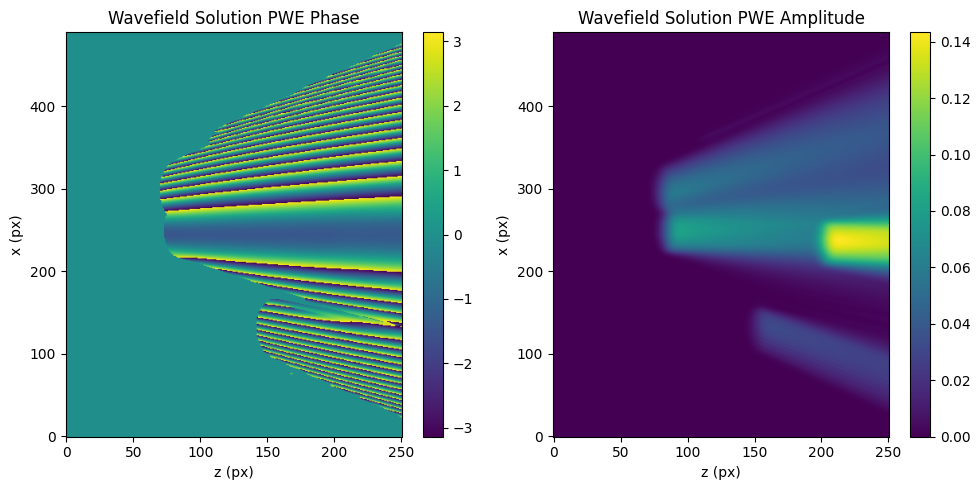

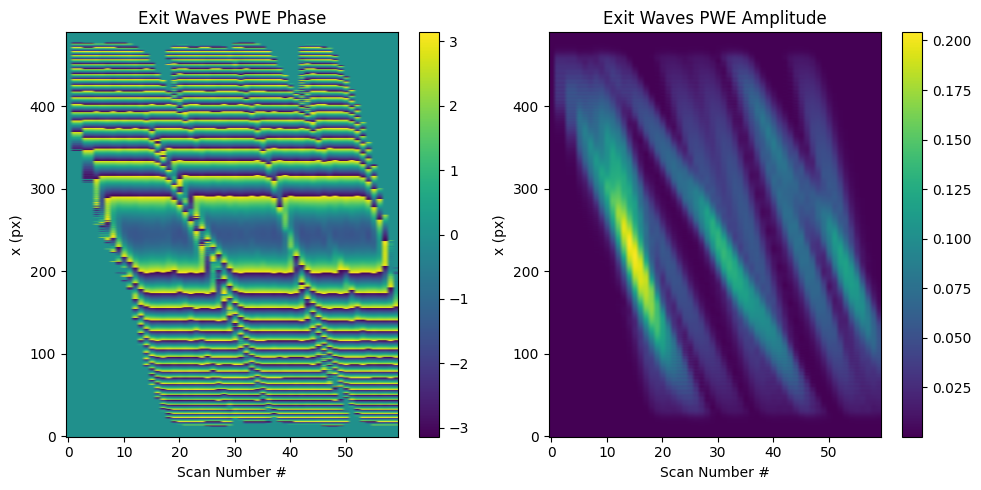

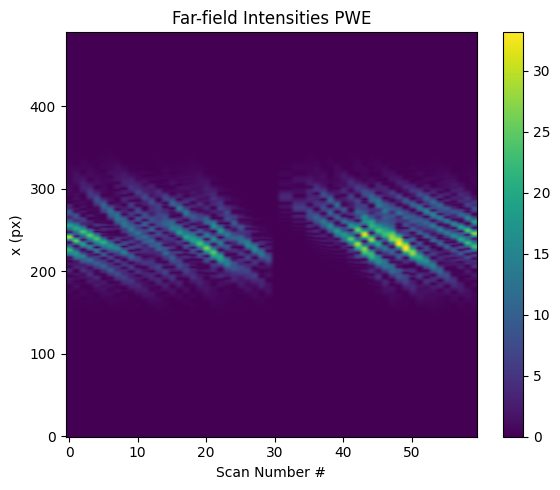

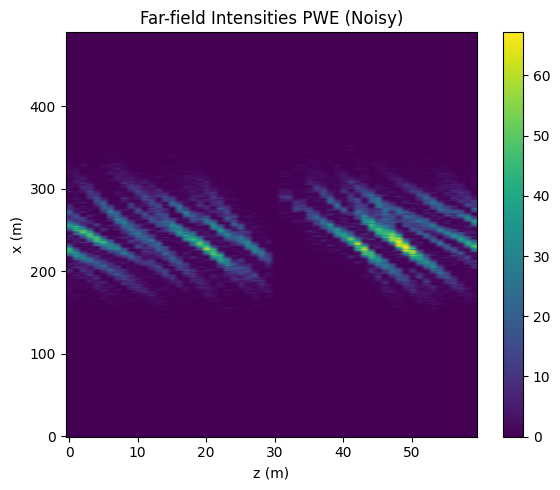

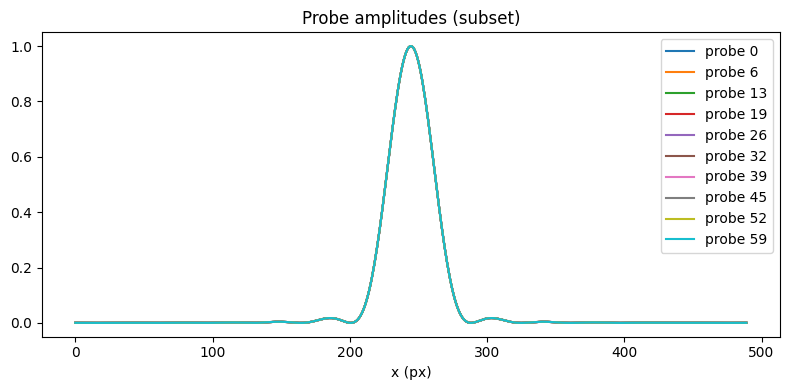

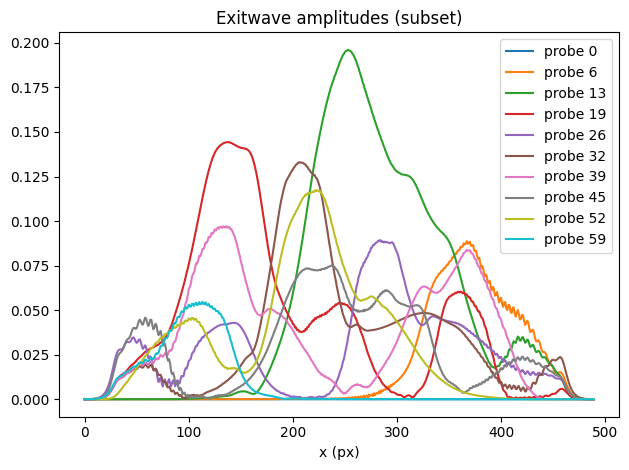

In [9]:
plot_solution(simulation_space, solution=u_pwe_empty)
plot_data(
    simulation_space, data=data_empty, exitwaves=data_ew_empty, probes=ptycho_probes
)

plot_solution(simulation_space, solution=u_pwe_empty - u_pwe)
plot_data(
    simulation_space,
    data=data_empty - data,
    exitwaves=data_ew_empty - data_ew,
    probes=ptycho_probes,
)

In [10]:
# recon_ms = ReconstructorMS(
#     simulation_space, data_ew, phase_retrieval=False, verbose=True
# )
# time_start = time.time()
# n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=10, alpha_obj=1e-4)
# time_end = time.time()
# print(f"Reconstruction time: {time_end - time_start:.2f} seconds")

# simulation_space.viewer.plot_two_panels(
#     n_est_ms,
#     view="phase_amp",
#     title="MS Reconstruction",
#     xlabel="z (px)",
#     ylabel="x (px)",
# )
# simulation_space.viewer.plot_residual(
#     residual_ms,
#     title="Residuals for MS Reconstruction",
# )

In [ ]:
recon_pwe = ReconstructorPWE(
    simulation_space, data_ew, phase_retrieval=False, verbose=True, 
    solver_type="full",
    alpha=1e-8,
    atol=1e-5,
)
time_start = time.time()
n_est_pwe, u, residual_pwe = recon_pwe.reconstruct(max_iters=10)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")

simulation_space.viewer.plot_two_panels(
    n_est_pwe,
    view="phase_amp",
    title="PWE Reconstruction",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_pwe,
    title="Residuals for PWE Reconstruction",
)

Pre-factorizing PiT preconditioner blocks...
PiT preconditioner block factorization time: 0.12 seconds.

Pre-factorizing PiT preconditioner blocks...


2025-12-14 03:31:37,984 - INFO - Initializing Least Squares Solver...
2025-12-14 03:31:37,990 - INFO - Iteration 1/10


PiT preconditioner block factorization time: 0.15 seconds.

Pre-factorizing PiT preconditioner blocks...
PiT preconditioner block factorization time: 0.15 seconds.

Setting up PETSc system...
PETSc system setup time: 0.01 seconds.
Solving with PETSc GMRES...
  Iter   0 | Residual: 5.277e+00
  Iter   1 | Residual: 9.829e-08
PETSc GMRES solve time: 0.04 s
Time: 0.04 s. Iters: 1. Reason: 3
[PWEPetscFullPinTSolver] solved probe 1/60 at angle _idx 0 in 0.06s
Setting up PETSc system...
PETSc system setup time: 0.01 seconds.
Solving with PETSc GMRES...
  Iter   0 | Residual: 1.015e-07
PETSc GMRES solve time: 0.01 s
Time: 0.01 s. Iters: 0. Reason: 3
[PWEPetscFullPinTSolver] solved probe 2/60 at angle _idx 0 in 0.02s
Setting up PETSc system...
PETSc system setup time: 0.00 seconds.
Solving with PETSc GMRES...
  Iter   0 | Residual: 1.015e-07
PETSc GMRES solve time: 0.01 s
Time: 0.01 s. Iters: 0. Reason: 3
[PWEPetscFullPinTSolver] solved probe 3/60 at angle _idx 0 in 0.02s
Setting up PETSc syste

2025-12-14 03:31:40,328 - INFO -     RMSE: 0.04689621791775046


Setting up PETSc system...
PETSc system setup time: 0.01 seconds.
Solving with PETSc GMRES...
  Iter   0 | Residual: 4.472e-03
PETSc GMRES solve time: 0.01 s
Time: 0.01 s. Iters: 0. Reason: 3
Setting up PETSc system...
PETSc system setup time: 0.01 seconds.
Solving with PETSc GMRES...
  Iter   0 | Residual: 2.337e-01
  Iter   1 | Residual: 2.308e-09
PETSc GMRES solve time: 0.07 s
Time: 0.07 s. Iters: 1. Reason: 3
Setting up PETSc system...
PETSc system setup time: 0.00 seconds.
Solving with PETSc GMRES...
  Iter   0 | Residual: 2.308e-09
PETSc GMRES solve time: 0.02 s
Time: 0.02 s. Iters: 0. Reason: 3
Setting up PETSc system...
PETSc system setup time: 0.00 seconds.
Solving with PETSc GMRES...
  Iter   0 | Residual: 2.425e-01
  Iter   1 | Residual: 2.362e-09
PETSc GMRES solve time: 0.05 s
Time: 0.05 s. Iters: 1. Reason: 3
Setting up PETSc system...
PETSc system setup time: 0.00 seconds.
Solving with PETSc GMRES...
  Iter   0 | Residual: 2.362e-09
PETSc GMRES solve time: 0.01 s
Time: 0.

2025-12-14 03:31:59,245 - INFO -     Iteration 1 took 21.25 seconds.
2025-12-14 03:31:59,247 - INFO - Iteration 2/10


Setting up PETSc system...
PETSc system setup time: 0.01 seconds.
Solving with PETSc GMRES...
  Iter   0 | Residual: 4.826e+07
PETSc GMRES solve time: 0.03 s
Time: 0.03 s. Iters: 0. Reason: -4
[PWEPetscFullPinTSolver] solved probe 1/60 at angle _idx 0 in 0.05s
Setting up PETSc system...
PETSc system setup time: 0.02 seconds.
Solving with PETSc GMRES...
  Iter   0 | Residual: 5.633e+07
PETSc GMRES solve time: 0.03 s
Time: 0.03 s. Iters: 0. Reason: -4
[PWEPetscFullPinTSolver] solved probe 2/60 at angle _idx 0 in 0.05s
Setting up PETSc system...
PETSc system setup time: 0.02 seconds.
Solving with PETSc GMRES...
  Iter   0 | Residual: 6.531e+07
PETSc GMRES solve time: 0.02 s
Time: 0.02 s. Iters: 0. Reason: -4
[PWEPetscFullPinTSolver] solved probe 3/60 at angle _idx 0 in 0.05s
Setting up PETSc system...
PETSc system setup time: 0.02 seconds.
Solving with PETSc GMRES...
  Iter   0 | Residual: 7.511e+07
PETSc GMRES solve time: 0.03 s
Time: 0.03 s. Iters: 0. Reason: -4
[PWEPetscFullPinTSolver]

2025-12-14 03:32:02,975 - INFO -     RMSE: 93.94659011324936


Setting up PETSc system...
PETSc system setup time: 0.00 seconds.
Solving with PETSc GMRES...
  Iter   0 | Residual: 5.434e+04
  Iter   1 | Residual: 4.518e+04
  Iter   2 | Residual: 4.510e+04
  Iter   3 | Residual: 4.169e+04
  Iter   4 | Residual: 4.055e+04
  Iter   5 | Residual: 3.991e+04
  Iter   6 | Residual: 3.763e+04
  Iter   7 | Residual: 3.737e+04
  Iter   8 | Residual: 3.664e+04
  Iter   9 | Residual: 3.507e+04
  Iter  10 | Residual: 3.478e+04
  Iter  11 | Residual: 3.407e+04
  Iter  12 | Residual: 3.309e+04
  Iter  13 | Residual: 3.305e+04
  Iter  14 | Residual: 3.204e+04
  Iter  15 | Residual: 3.177e+04
  Iter  16 | Residual: 3.132e+04
  Iter  17 | Residual: 3.070e+04
  Iter  18 | Residual: 3.070e+04
  Iter  19 | Residual: 3.009e+04
  Iter  20 | Residual: 2.992e+04
PETSc GMRES solve time: 0.95 s
Time: 0.95 s. Iters: 20. Reason: -3
Setting up PETSc system...
PETSc system setup time: 0.00 seconds.
Solving with PETSc GMRES...
  Iter   0 | Residual: 3.135e+04
  Iter   1 | Residu

KeyboardInterrupt: 